In [1]:
%load_ext Cython
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as pyplot
import optuna as op
%matplotlib inline
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

In [2]:
dataset = pd.read_csv('../Input/interactions_and_impressions.csv')
dataset = dataset.drop(columns=['Impressions'])

datasetCOO = sp.coo_matrix((dataset["Data"].values, (dataset["UserID"].values, dataset["ItemID"].values)))
userIDS = dataset['UserID'].unique()
itemIDS = dataset['ItemID'].unique()

URM = np.zeros((len(userIDS), len(itemIDS)), dtype=int)
for x in range(len(datasetCOO.data)):
    if datasetCOO.data[x] == 0:
        URM[datasetCOO.row[x]][datasetCOO.col[x]] = int(1)

URM = sp.csr_matrix(URM)

/var/folders/tt/9v6608x550n51759gpcrffsc0000gn/T/ipykernel_13458/4045740091.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../Input/interactions_and_impressions.csv')


In [3]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

In [4]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2664 ( 6.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1617 ( 3.9%) Users that have less than 1 test interactions


## Number of Neighbors

In [5]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

x_tick = [10, 25, 40, 50, 100]
MAP_per_k = []

for topK in x_tick:

    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 2090.37 column/sec. Elapsed time 19.91 sec
EvaluatorHoldout: Processed 38965 (100.0%) in 13.07 sec. Users per second: 2982
UserKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 2086.09 column/sec. Elapsed time 19.96 sec
EvaluatorHoldout: Processed 38965 (100.0%) in 13.70 sec. Users per second: 2844
UserKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 2055.50 column/sec. Elapsed 

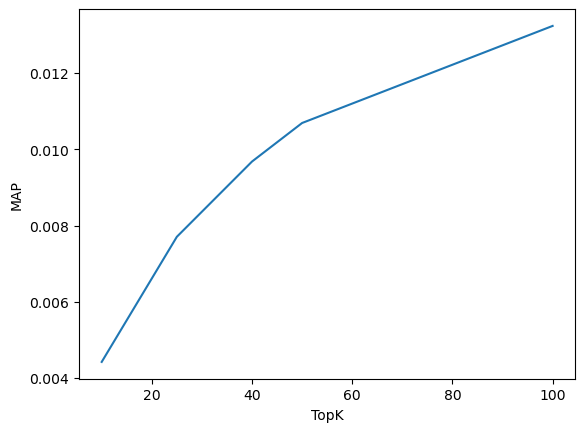

In [6]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

## Shrinkage

In [7]:
x_tick = [0, 10, 50, 100]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 1870.46 column/sec. Elapsed time 22.26 sec
EvaluatorHoldout: Processed 38965 (100.0%) in 15.14 sec. Users per second: 2574
UserKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 1866.44 column/sec. Elapsed time 22.30 sec
EvaluatorHoldout: Processed 38965 (100.0%) in 15.36 sec. Users per second: 2537
UserKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 1904.06 column/sec. Elapsed 

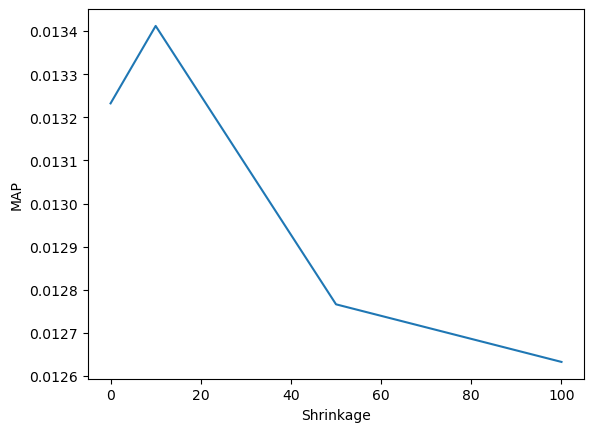

In [8]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

## Testing of recommenders

In [9]:
collaborative_recommender1 = UserKNNCFRecommender(URM_train)
# collaborative_recommender1.fit(shrink=10, topK=20)

collaborative_recommender2 = UserKNNCFRecommender(URM_train)
# collaborative_recommender2.fit(shrink=100, topK=25)

collaborative_MAP1 = []
collaborative_MAP2 = []

x_tick = []

for topK in [20, 40]:
    for shrink in [15, 20]:
        x_tick.append("topk {}, shrink {}".format(topK, shrink))

        collaborative_recommender1.fit(shrink=shrink, topK=topK)
        collaborative_recommender2.fit(shrink=shrink, topK=topK)

        result_df, _ = evaluator_test.evaluateRecommender(collaborative_recommender1)
        collaborative_MAP1.append(result_df.loc[10]["MAP"])

        result_df, _ = evaluator_test.evaluateRecommender(collaborative_recommender2)
        collaborative_MAP2.append(result_df.loc[10]["MAP"])

UserKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) items with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 2091.91 column/sec. Elapsed time 19.90 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 2118.80 column/sec. Elapsed time 19.65 sec
EvaluatorHoldout: Processed 40012 (100.0%) in 13.78 sec. Users per second: 2903
EvaluatorHoldout: Processed 40012 (100.0%) in 13.81 sec. Users per second: 2898
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 2094.89 column/sec. Elapsed time 19.87 sec
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 2089.59 column/sec. Elapsed time 19

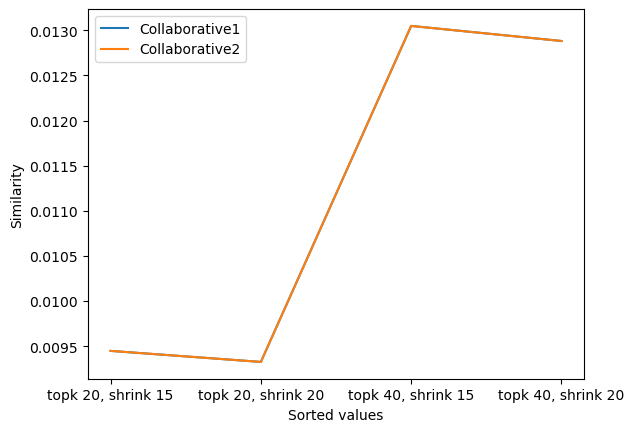

In [10]:
pyplot.plot(x_tick, collaborative_MAP1, label="Collaborative1")
pyplot.plot(x_tick, collaborative_MAP2, label="Collaborative2")

pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

## OPTUNA optimization

In [15]:
recommender = UserKNNCFRecommender(URM_train)

def objective(trial):
    topK = trial.suggest_float("topK", 30, 60)
    shrink = trial.suggest_float("shrink", 10, 25)
    recommender.fit(topK=int(topK), shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

UserKNNCFRecommender: URM Detected 1 ( 0.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 1 ( 0.0%) items with no interactions.


In [16]:
study = op.create_study(direction='minimize')
study.optimize(objective, n_trials=3)

[I 2022-11-02 15:58:04,029] A new study created in memory with name: no-name-af2b3c5c-4767-4be8-b367-ed0507eae41f


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 2031.14 column/sec. Elapsed time 20.50 sec
EvaluatorHoldout: Processed 38965 (100.0%) in 14.17 sec. Users per second: 2749


[I 2022-11-02 15:58:38,744] Trial 0 finished with value: 0.010701425169922809 and parameters: {'topK': 46.70157815193499, 'shrink': 14.05474304247996}. Best is trial 0 with value: 0.010701425169922809.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 2066.70 column/sec. Elapsed time 20.14 sec
EvaluatorHoldout: Processed 38965 (100.0%) in 13.80 sec. Users per second: 2824


[I 2022-11-02 15:59:12,710] Trial 1 finished with value: 0.009064818039795777 and parameters: {'topK': 31.195369834225907, 'shrink': 16.9579146232028}. Best is trial 1 with value: 0.009064818039795777.


Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 41629 (100.0%), 1911.25 column/sec. Elapsed time 21.78 sec
EvaluatorHoldout: Processed 38965 (100.0%) in 14.36 sec. Users per second: 2713


[I 2022-11-02 15:59:48,884] Trial 2 finished with value: 0.011183952224116743 and parameters: {'topK': 54.19117752303161, 'shrink': 16.87530695868369}. Best is trial 1 with value: 0.009064818039795777.


In [17]:
topK = study.best_params['topK']
shrink = study.best_params['shrink']

In [18]:
topK

31.195369834225907

In [19]:
shrink

16.9579146232028